In [1]:
# -*- coding: utf-8 -*-
#    Copyright (C) 2022 Maicon Marques Alves (maicon.alves@ufsc.br)
#                       Dirk A. Lorenz (d.lorenz@uni-bremen.de)
#                       Emanuele Naldi (naldi@dima.unige.it)
#
#    This file is part of the example code repository for the paper:
#
#      M. M. Alves, D. A. Lorenz, E. Naldi.
#      A  general framework for inexact splitting algorithms with relative errors and applications to Chambolle-Pock and Davis-Yin methods,
#      2024. https://arxiv.org/pdf/2407.05893
#
#    This program is free software: you can redistribute it and/or modify
#    it under the terms of the GNU General Public License as published by
#    the Free Software Foundation, either version 3 of the License, or
#    (at your option) any later version.
#
#    This program is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#    GNU General Public License for more details.
#
#    You should have received a copy of the GNU General Public License
#    along with this program.  If not, see <https://www.gnu.org/licenses/>.

"""
This file contains all the experiments in Section 4.2 in:

M. M. Alves, D. A. Lorenz, E. Naldi.
A  general framework for inexact splitting algorithms with relative errors and applications to Chambolle-Pock and Davis-Yin methods,
2024. https://arxiv.org/pdf/2407.05893
"""

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import scipy as sc

# Helper functions

# Huber loss
delta = 0.1
def Huber(x):
    out = 0
    for xi in x:
        if np.linalg.norm(xi) > delta:
            out = out + delta*(np.linalg.norm(xi)-delta/2)
            # out = delta*(np.linalg.norm(xi)-delta/2)
        else:
            out = out + np.linalg.norm(xi)**2/2
    return out

# Soft tresholding operator 
def softt(x, beta):
    return np.maximum(np.abs(x) - beta, 0) * np.sign(x)

# Clip operator
def clip(x, beta):
    return np.maximum(np.minimum(x, beta), -beta)

# Gradient of Huber loss composed with D
def Grad(x):
        y = np.dot(D,x)
        out = y
        for i in range(n-1):
            if np.abs(y[i]) > delta:
                out[i] = delta*np.sign(y[i])
        return np.dot(D.T,out)

# Experiment
def experiment(H,f,lambda_val_1,lambda_val_2,maxiter,sigma_HPE):

    m,n = H.shape

    def obj(x, lambda_val_1, lamda_val_2):
        return np.linalg.norm(np.dot(H, x) - f, 2)**2/2 + lambda_val_1 * np.linalg.norm(x, 1) + lambda_val_2 * Huber(np.dot(D, x))
        
    check = round(maxiter/10)

    # start HPE for DY
    # cocoercivity constant beta is lambda_val_2*||D||^2*Lipschitz(Grad), bounded by 4*
    beta = lambda_val_2*4
    # stepsizes (gamma < 2/beta, guaranteed by putting gamma = 1/beta)
    gamma = 1/beta
    # stepsizes (considering beta = 4 as above, alpha = gamma*beta/(4-gamma*beta) is guaranteed by the following)
    alpha = gamma*beta/(4-gamma*beta)
    # algorithm parameter
    sigma = sigma_HPE  # (between 0 and 1)

    print('Starting HPE for DY')
    times = np.zeros(maxiter+1)
    objective = np.zeros(maxiter+1)
    iters = np.zeros(maxiter+1)
    matvecsH_HPE = np.zeros(maxiter+1)
    
    # initialize
    w = np.zeros(n)
    x1tilde = np.zeros(n)
    objective[0] = obj(x1tilde,lambda_val_1,lambda_val_2)
    times[0] = 0
    iters[0] = 0

    start = time.time()
    for k in range(maxiter):
        stopped = False
        # here comes the CG iteration
        def A(z):
            return z + gamma * np.dot(H.T,np.dot(H, z))

        # rhs of linear equation to solve (not the rhs of the HPE condition...)
        rhs = w + gamma * HTf
        # CG init
        r = rhs - A(x1tilde)  # residual
        p = r  # aux variable
        if np.linalg.norm(p,2) < 1e-8:
            stopped = True
        j = 0  # counter
        while not stopped:
            # one CG step with A = I + lambda*H'*H and right hand side rhs
            Ap = A(p)
            alpha_inner = np.linalg.norm(r, 2)**2 / (p.dot(Ap))
            x1tilde = x1tilde + alpha_inner * p

            # check if stopping criterion fulfilled
            a = (np.dot(H.T,np.dot(H, x1tilde)) - HTf)
            x2tilde = softt(2*x1tilde - w - gamma*lambda_val_2*Grad (x1tilde), gamma*lambda_val_1)
            
            # Left and right hand sides for the HPE condition
            LHS = np.linalg.norm(gamma * a - w + x1tilde)
            RHS = sigma * np.linalg.norm(gamma*a - w + (alpha*x1tilde + x2tilde)/(1+alpha))
            if LHS <= RHS or j > 200:
                stopped = True
                cgiter = j + 1
            rold = r
            r = r - alpha_inner * Ap
            beta_inner = np.linalg.norm(r, 2)**2 / np.linalg.norm(rold, 2)**2
            p = r + beta_inner * p
            j += 1
        w = w + (x2tilde-x1tilde)/(1+alpha)
        iters[k+1] = j
        times[k+1] = time.time() - start
        objective[k+1] = obj(x1tilde, lambda_val_1, lambda_val_2)
        matvecsH_HPE[k+1] = matvecsH_HPE[k] + j
        if k % check == 0:
            print('k = %d, Obj(ztilde): %f, cgiter: %d' % (k, objective[k],cgiter))

    xHPE = x1tilde
    HPE_DY_time = time.time() - start
    print('HPE for DY after %d iterations in %f seconds.' % (k, HPE_DY_time))
    print('Total numbers of CG iterations: %d' % (matvecsH_HPE[-1]))
    print('Final objective: %e.\n\n' % objective[-1])

    # start DY
    # cocoercivity constant beta is lambda_val_2*||D||^2, bounded by 4
    beta = lambda_val_2*4
    # stepsizes (gamma < 2/beta, guaranteed by putting gamma = 1/beta)
    gamma = 1/beta
    # stepsizes (considering beta = 4 as above, alpha = gamma*beta/(4-gamma*beta) is guaranteed by the following)
    alpha = gamma*beta/(4-gamma*beta)
    # algorithm parameter
    sigma = sigma_HPE  # (between 0 and 1)

    print('Starting DY')
    # initialize
    def A(z):
        return z + gamma * np.dot(H.T,np.dot(H, z))
    Aop = sc.sparse.linalg.LinearOperator((n,n), matvec=A)

    times_DY = np.zeros(maxiter+1)
    objective_DY = np.zeros(maxiter+1)
    iters = np.zeros(maxiter+1)
    itersiDY_CG = np.zeros(maxiter+1)
    matvecsH_DY = np.zeros(maxiter+1)
    
    w = np.zeros(n)
    x1 = np.zeros(n)
    objective_DY[0] = obj(x1,lambda_val_1,lambda_val_2)
    times_DY[0] = 0
    itersiDY_CG[0] = 0

    def callback(arr):
        callback.iterations +=1

    start = time.time()
    INV = np.linalg.inv(np.eye(n) + gamma*HTH)

    for k in range(maxiter):
        callback.iterations = 0
        x1, info = sc.sparse.linalg.cg(Aop, w + gamma * HTf, x0=x1,tol = 1e-8, atol=1e-8,callback=callback)
        x2 = softt(2*x1 - w - gamma*lambda_val_2*Grad(x1), gamma*lambda_val_1)
        w = w + (x2-x1)/(1+alpha)
        times_DY[k+1] = time.time() - start
        objective_DY[k+1] = obj(x1, lambda_val_1, lambda_val_2)
        itersiDY_CG[k+1] = callback.iterations
        matvecsH_DY[k+1] = matvecsH_DY[k] + callback.iterations

    xDY = x1
    DY_time = time.time() - start
    print('DY after %d iterations in %f seconds.' % (k, DY_time))
    print('Total numbers of CG iterations: %d' % (np.sum(itersiDY_CG)))
    print('Final objective: %e.\n\n' % objective_DY[-1])


    #################

    print('Starting FB')
    
    # Full gradient to test FB (coincide with the operator \tilde{B} in the manuscript)
    def FullGrad(x):
        return lambda_val_2*Grad(x) + np.dot(H.T,np.dot(H,x)-f)

    # start FB
    # cocoercivity constant beta is lambda_val_2*||D||^2, bounded by 4
    beta = lambda_val_2*4 + np.linalg.norm(np.dot(H.T,H),2)
    # stepsizes (gamma < 2/beta, guaranteed by putting gamma = 1/beta)
    gamma = 1/beta

    times_FB = np.zeros(maxiter+1)
    objective_FB = np.zeros(maxiter+1)
    iters = np.zeros(maxiter+1)
    matvecsH_FB = np.zeros(maxiter+1)
    # initialize
    x = np.zeros(n)
    objective_FB[0] = obj(x,lambda_val_1,lambda_val_2)
    times_FB[0] = 0

    start = time.time()
    for k in range(maxiter):
        x = softt(x - gamma*FullGrad(x), gamma*lambda_val_1)

        times_FB[k+1] = time.time() - start
        objective_FB[k+1] = obj(x, lambda_val_1, lambda_val_2)
        matvecsH_FB[k+1] = matvecsH_FB[k] + 1

    xFB = x
    FB_time = time.time() - start
    print('DY after %d iterations in %f seconds.' % (k, FB_time))
    print('Final objective: %e.\n\n' % objective_FB[-1])

    #################
    
    # Plots
    
    obj_min = min(np.min(objective),np.min(objective_DY),np.min(objective_FB))

    fig1 = plt.figure(1,figsize=(10,5))
    plt.subplot(1, 2, 1)
    #plt.plot(range(1, maxiter + 2), objective, range(1, maxiter + 2), objectiveicp, range(1, maxiter + 2), objectivecp, range(1, maxiter + 2), objectivecv)
    plt.semilogy(range(1, maxiter + 2), objective-obj_min, range(1, maxiter + 2), objective_DY-obj_min, range(1, maxiter + 2), objective_FB-obj_min)
    plt.xlabel('iterations')
    plt.ylabel('distance to minimal objective')
    plt.xlim(0,maxiter-100)
    plt.legend(['HPE DY', 'implicit DY', 'FB'])
    #plt.axis([0, 2000, 0, 0.5])

    plt.subplot(1, 2, 2)
    # plt.plot(times[:k], objective[:k], timesicp[:k], objectiveicp[:k], timescp[:k], objectivecp[:k], timescv[:k], objectivecv[:k])
    # plt.semilogy(times[:k], objective[:k]-obj_min, times_DY[:k], objective_DY[:k]-obj_min,times_FB[:k], objective_FB[:k]-obj_min)
    plt.semilogy(matvecsH_HPE[:k], objective[:k]-obj_min, matvecsH_DY[:k], objective_DY[:k]-obj_min, matvecsH_FB[:k], objective_FB[:k]-obj_min)
    plt.xlabel('number of matvecs with H and H^T')
    plt.ylabel('distance to minimal objective')
    plt.xlim(0,maxiter-100)
    plt.legend(['HPE DY', 'implicit DY','FB'])
    #plt.axis([0, 5, 0, 0.5])

    plt.savefig(f'../Experiment_DY_lambda1_{lambda_val_1}_lambda2_{lambda_val_2}.pdf')


    print(np.linalg.norm(xHPE-xdag,2))
    print(np.linalg.norm(xDY-xdag,2))
    print(np.linalg.norm(xFB-xdag,2))

C:\Users\emanu\anaconda3\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Starting HPE for DY
k = 0, Obj(ztilde): 87.910279, cgiter: 1
k = 30, Obj(ztilde): 0.983867, cgiter: 1
k = 60, Obj(ztilde): 0.921600, cgiter: 1
k = 90, Obj(ztilde): 0.921419, cgiter: 1
k = 120, Obj(ztilde): 0.921418, cgiter: 1
k = 150, Obj(ztilde): 0.921418, cgiter: 1
k = 180, Obj(ztilde): 0.921418, cgiter: 2
k = 210, Obj(ztilde): 0.921418, cgiter: 1
k = 240, Obj(ztilde): 0.921418, cgiter: 1
k = 270, Obj(ztilde): 0.921418, cgiter: 1
HPE for DY after 299 iterations in 12.492579 seconds.
Total numbers of CG iterations: 277
Final objective: 9.214176e-01.


Starting DY
DY after 299 iterations in 15.150656 seconds.
Total numbers of CG iterations: 1126
Final objective: 9.214176e-01.


Starting FB
DY after 299 iterations in 12.283553 seconds.
Final objective: 9.214176e-01.


0.9981025282194795
0.9981025816369243
0.9981069159672724


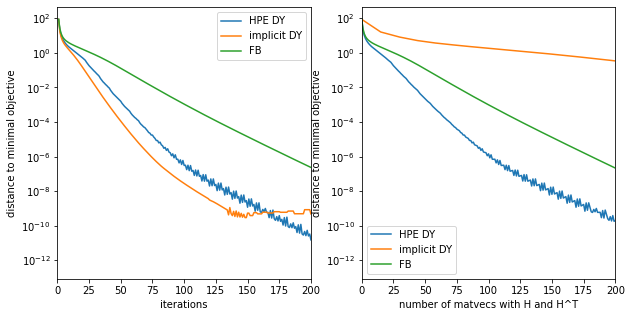

In [3]:
np.random.seed(183763)
# set up the data
m = 2000
n = 2000

# Generate ill conditioned matrix with prescribed spectrum
H = np.random.randn(m,n)
U,S,VT = np.linalg.svd(H)
S = np.zeros((m,n))
xx = np.linspace(0,1,min(m,n))
np.fill_diagonal(S,0.5+0.5*np.cos(3.1415*xx))
H = U@S@VT

# Difference matrix
D = np.diag(np.ones(n)) - np.diag(np.ones(n-1), 1)
D = D[:n-1, :]

# Generate data
t = np.linspace(0, 1, n)
xdag = 0.5 * (np.abs(t - 0.2) < 0.07) + 0.7 * (np.abs(t - 0.6) < 0.2)
f = np.dot(H, xdag) + 0.02 * np.random.randn(m)
HTf = np.dot(H.T, f)
HTH = np.dot(H.T, H)

experiment(H,f,lambda_val_1=0.001,lambda_val_2=0.1,maxiter=300,sigma_HPE = 0.99)

Starting HPE for DY
k = 0, Obj(ztilde): 87.910279, cgiter: 1
k = 30, Obj(ztilde): 0.347737, cgiter: 1
k = 60, Obj(ztilde): 0.281118, cgiter: 1
k = 90, Obj(ztilde): 0.280616, cgiter: 1
k = 120, Obj(ztilde): 0.280611, cgiter: 1
k = 150, Obj(ztilde): 0.280611, cgiter: 1
k = 180, Obj(ztilde): 0.280611, cgiter: 1
k = 210, Obj(ztilde): 0.280611, cgiter: 2
k = 240, Obj(ztilde): 0.280611, cgiter: 2
k = 270, Obj(ztilde): 0.280611, cgiter: 1
HPE for DY after 299 iterations in 13.714346 seconds.
Total numbers of CG iterations: 288
Final objective: 2.806108e-01.


Starting DY
DY after 299 iterations in 15.744519 seconds.
Total numbers of CG iterations: 1170
Final objective: 2.806108e-01.


Starting FB
DY after 299 iterations in 21.173489 seconds.
Final objective: 2.806108e-01.


1.0491235153754306
1.0491235307101447
1.049123600472778


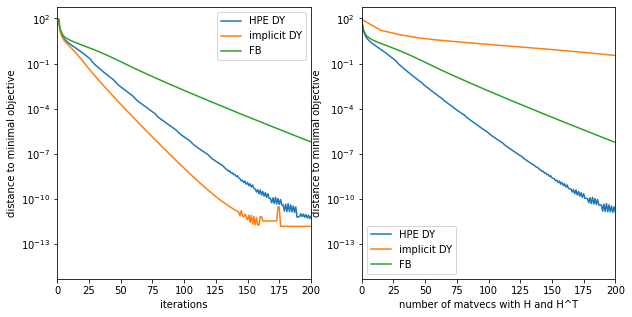

In [4]:
experiment(H,f,lambda_val_1=0.0001,lambda_val_2=0.1,maxiter=300,sigma_HPE = 0.99)

Starting HPE for DY
k = 0, Obj(ztilde): 87.910279, cgiter: 2
k = 30, Obj(ztilde): 0.181231, cgiter: 2
k = 60, Obj(ztilde): 0.180637, cgiter: 3
k = 90, Obj(ztilde): 0.180637, cgiter: 3
k = 120, Obj(ztilde): 0.180637, cgiter: 3
k = 150, Obj(ztilde): 0.180637, cgiter: 3
k = 180, Obj(ztilde): 0.180637, cgiter: 1
k = 210, Obj(ztilde): 0.180637, cgiter: 3
k = 240, Obj(ztilde): 0.180637, cgiter: 2
k = 270, Obj(ztilde): 0.180637, cgiter: 1
HPE for DY after 299 iterations in 30.310052 seconds.
Total numbers of CG iterations: 527
Final objective: 1.806367e-01.


Starting DY
DY after 299 iterations in 28.558977 seconds.
Total numbers of CG iterations: 1733
Final objective: 1.806367e-01.


Starting FB
DY after 299 iterations in 23.350362 seconds.
Final objective: 1.852355e-01.


2.023015277008395
2.0230157645005185
2.3867010010808065


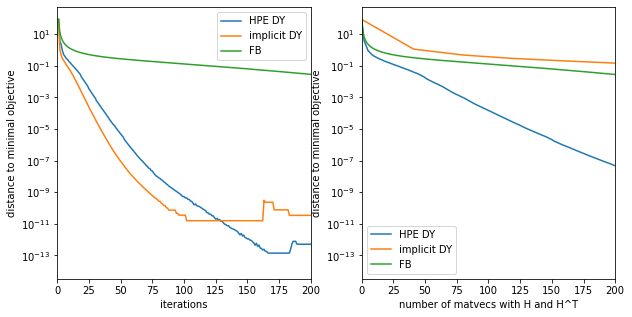

In [5]:
experiment(H,f,lambda_val_1=0.0001,lambda_val_2=0.01,maxiter=300,sigma_HPE = 0.99)